<a href="https://colab.research.google.com/github/tronglinux123/EHR_Transfer_Learning/blob/main/DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.cloud import bigquery
from google.colab import auth, drive
import os
# Mount to Google Drive if data on Drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/doan_demo')
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/doan_demo'

In [ ]:
from typing import Callable
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import warnings
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import gc
warnings.filterwarnings('ignore')



In [ ]:
df = pd.read_csv('x_ray_and_features_data.csv')

diseases = ['pneumonia', 'tuberculosis', 'bronchitis', 'arthritis', 'fracture', 'lung_cancer', 'scoliosis', 'lung_infection']
mimic_feats = ['diabete', 'age', 'hiv', 'oxygen', 'heart_rate', 'temperature', 'hemoglobin', 'rbc', 'wbc', 'smoke', 'cough']
img_feats = [str(x) for x in range(18)]
models = [XGBClassifier]
# Keep the necessary data
data = df[img_feats+mimic_feats]
y = df["pneumonia"]
xtr, xte, ytr, yte = train_test_split(data, y, test_size=0.35)
xtr = xtr.reset_index(drop=True)
ytr = ytr.reset_index(drop=True)
xtr

,0,1,2,3,4,5,6,7,8,9,...,age,hiv,oxygen,heart_rate,temperature,hemoglobin,rbc,wbc,smoke,cough
0,0.856242,-1.470453,1.117912e-39,-4.006925,-0.386026,-8.627420e-40,-2.084280e-39,0.193751,-1.698623,3.912998e-39,...,91,0,NaN,NaN,NaN,14.9,5.14,7.1,0,0
1,0.831896,-0.041840,-8.851540e-40,-3.207264,0.754563,-9.765680e-40,9.305210e-40,0.623604,-0.516955,2.885869e-39,...,80,0,NaN,NaN,NaN,7.2,2.55,7.7,0,0
2,-1.899727,-2.557168,3.806278e-39,-3.168871,-1.468932,1.358532e-39,4.534360e-40,-1.675298,-3.984909,-1.519668e-39,...,46,0,NaN,NaN,NaN,10.1,3.29,4.1,0,0
3,1.983838,2.022925,-1.033420e-39,-3.809005,1.222515,-1.458293e-39,4.515670e-40,3.482653,-0.884112,3.398606e-39,...,69,0,NaN,NaN,NaN,10.0,3.59,3.1,0,0
4,1.859526,1.281903,-9.649960e-40,-2.584149,0.829963,-2.116862e-39,9.096500e-40,2.426933,-0.563089,2.743082e-39,...,68,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18898,-0.118710,-0.753247,1.186108e-39,-2.117598,-0.597615,-8.320200e-41,2.362663e-39,0.100815,-1.332028,8.921350e-40,...,74,0,NaN,NaN,NaN,10.5,3.74,4.7,0,0
18899,2.648575,1.691695,-1.483259e-39,-3.444798,1.088337,-3.036639e-39,-3.080778e-39,3.291978,-0.204171,6.510707e-39,...,80,0,NaN,70.0,97.3,9.4,3.38,6.4,0,0
18900,0.796619,-0.594869,1.275036e-39,-4.146469,0.047674,-5.269550e-40,-1.741320e-40,1.237719,-2.111629,2.032595e-39,...,77,0,NaN,NaN,NaN,7.6,2.97,5.0,0,0
18901,0.618547,-0.816166,-6.940000e-42,-2.351794,-0.256115,-1.800457e-39,2.086580e-39,0.472418,-1.492969,9.766150e-40,...,73,0,NaN,NaN,NaN,10.3,3.51,12.1,0,0


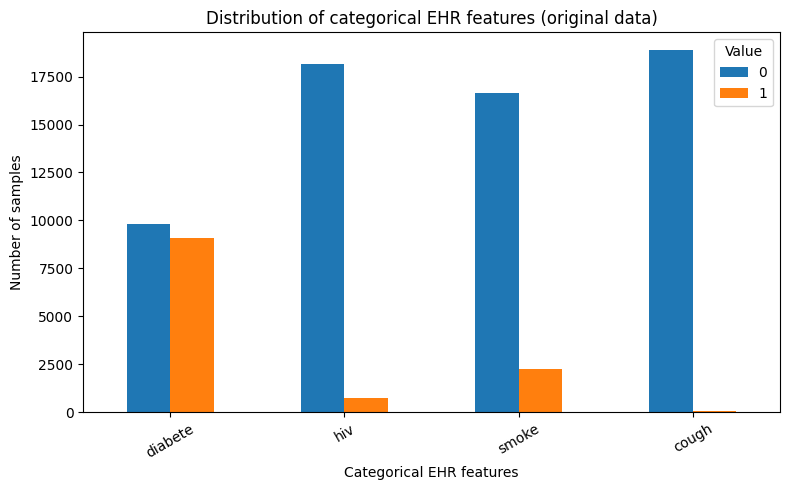

In [ ]:
cat_feats = ['diabete', 'hiv', 'smoke', 'cough']

import matplotlib.pyplot as plt
import pandas as pd

summary_cat = {}

for col in cat_feats:
    counts = xtr[col].value_counts()
    summary_cat[col] = {
        '0': counts.get(0, 0),
        '1': counts.get(1, 0)
    }

df_cat = pd.DataFrame(summary_cat).T

df_cat.plot(kind='bar', figsize=(8,5))
plt.xlabel('Categorical EHR features')
plt.ylabel('Number of samples')
plt.title('Distribution of categorical EHR features (original data)')
plt.xticks(rotation=30)
plt.legend(title='Value')
plt.tight_layout()
plt.show()


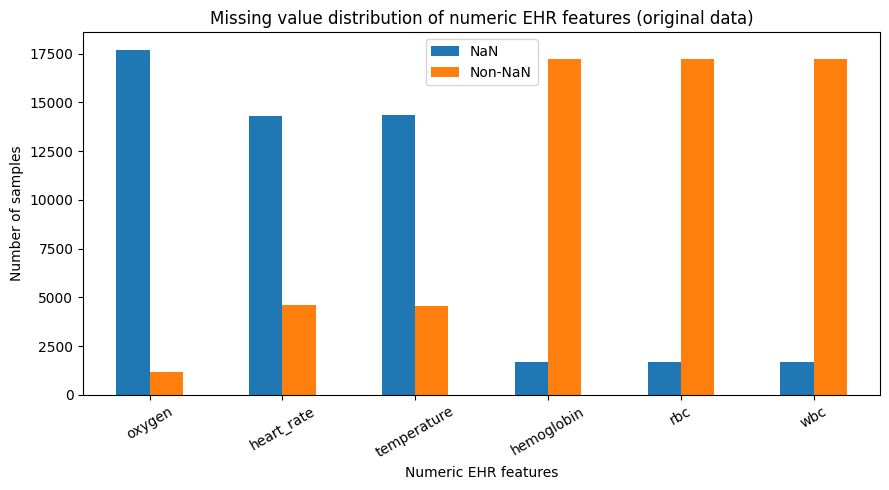

In [ ]:
mimic_numeric = ['oxygen', 'heart_rate', 'temperature',
                 'hemoglobin', 'rbc', 'wbc']

summary_num = {}

for col in mimic_numeric:
    summary_num[col] = {
        'NaN': xtr[col].isna().sum(),
        'Non-NaN': xtr[col].notna().sum()
    }

df_num = pd.DataFrame(summary_num).T

df_num.plot(kind='bar', figsize=(9,5))
plt.xlabel('Numeric EHR features')
plt.ylabel('Number of samples')
plt.title('Missing value distribution of numeric EHR features (original data)')
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()

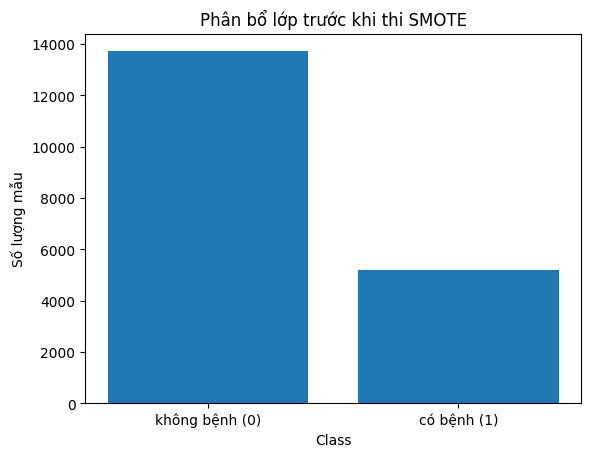

In [ ]:

counts = ytr.value_counts().sort_index()

plt.figure()
plt.bar(['không bệnh (0)', 'có bệnh (1)'], counts.values)
plt.xlabel('Class')
plt.ylabel('Số lượng mẫu')
plt.title('Phân bổ lớp trước khi thi SMOTE')
plt.show()

In [ ]:
full_feats = img_feats + mimic_feats

sm = SMOTE(sampling_strategy=1, random_state=42)
xtr_img_sm, ytr_sm = sm.fit_resample(xtr[img_feats], ytr)
xtr_img_sm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.856242,-1.470453,1.117912e-39,-4.006925,-0.386026,-8.627420e-40,-2.084280e-39,0.193751,-1.698623,3.912998e-39,1.494754,2.457758e-39,-8.483280e-40,-3.030997e-39,-1.991644,-1.421727,1.176656,-0.515828
1,0.831896,-0.041840,-8.851540e-40,-3.207264,0.754563,-9.765680e-40,9.305210e-40,0.623604,-0.516955,2.885869e-39,0.618043,1.235973e-39,-7.966400e-40,2.724300e-41,-0.622705,-0.963172,1.639094,-0.531474
2,-1.899727,-2.557168,3.806278e-39,-3.168871,-1.468932,1.358532e-39,4.534360e-40,-1.675298,-3.984909,-1.519668e-39,-2.605859,-1.953993e-39,-6.810370e-40,-1.443734e-39,-2.729483,-1.207243,-0.935856,-1.400174
3,1.983838,2.022925,-1.033420e-39,-3.809005,1.222515,-1.458293e-39,4.515670e-40,3.482653,-0.884112,3.398606e-39,2.853422,7.101200e-41,4.080080e-40,-7.378560e-39,-1.943483,-1.264098,2.815750,0.972516
4,1.859526,1.281903,-9.649960e-40,-2.584149,0.829963,-2.116862e-39,9.096500e-40,2.426933,-0.563089,2.743082e-39,0.627204,7.751630e-40,-4.617339e-39,-6.319876e-39,0.479003,0.412602,2.311904,0.547638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27431,1.314655,-0.524357,6.120979e-40,-3.360817,-0.088115,6.665970e-40,1.447505e-39,1.126122,-1.264672,2.539812e-39,0.164073,4.447762e-40,8.336270e-40,-1.657026e-39,-1.184311,-0.892073,1.701102,-1.052986
27432,-0.451817,-2.294229,1.568861e-39,-4.110234,-0.422296,6.482883e-40,1.109287e-39,-0.671879,-2.014987,1.101972e-39,-1.239502,4.914694e-40,8.829709e-40,-2.221830e-39,-2.730650,-2.032493,0.224884,-2.461204
27433,0.218326,-3.026485,-2.645545e-41,-3.765365,-0.990047,-4.466595e-39,-1.860362e-39,-1.392493,-1.037514,2.442908e-39,0.989584,1.834395e-39,-1.719270e-39,-5.780515e-39,-0.377224,0.062722,0.794800,-0.865291
27434,0.110651,-0.169059,3.897490e-40,-2.435419,-0.581928,-6.517955e-40,3.000839e-39,0.820376,-1.077453,4.680284e-40,-1.724628,9.498975e-40,-1.726743e-39,-3.533308e-39,-0.509347,-0.537239,0.976341,-1.488838


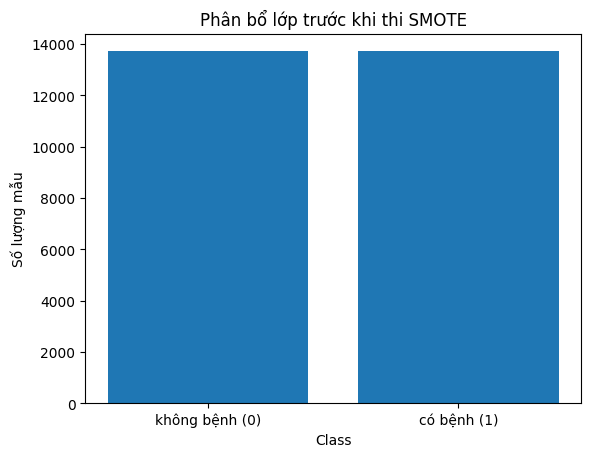

In [ ]:

counts = ytr_sm.value_counts().sort_index()

plt.figure()
plt.bar(['không bệnh (0)', 'có bệnh (1)'], counts.values)
plt.xlabel('Class')
plt.ylabel('Số lượng mẫu')
plt.title('Phân bổ lớp trước khi thi SMOTE')
plt.show()

In [ ]:
n_original = len(xtr)
n_total = len(xtr_img_sm)
n_synthetic = n_total - n_original
n_synthetic

8533

In [ ]:
xtr_final = pd.DataFrame()
xtr_final[img_feats] = xtr_img_sm
xtr_final.loc[:n_original-1, mimic_feats] = xtr[mimic_feats].values
xtr_final.loc[n_original:, mimic_feats] = np.nan
X_train_final = xtr_final
y_train_final = ytr_sm
X_train_final

,0,1,2,3,4,5,6,7,8,9,...,age,hiv,oxygen,heart_rate,temperature,hemoglobin,rbc,wbc,smoke,cough
0,0.856242,-1.470453,1.117912e-39,-4.006925,-0.386026,-8.627420e-40,-2.084280e-39,0.193751,-1.698623,3.912998e-39,...,91.0,0.0,NaN,NaN,NaN,14.9,5.14,7.1,0.0,0.0
1,0.831896,-0.041840,-8.851540e-40,-3.207264,0.754563,-9.765680e-40,9.305210e-40,0.623604,-0.516955,2.885869e-39,...,80.0,0.0,NaN,NaN,NaN,7.2,2.55,7.7,0.0,0.0
2,-1.899727,-2.557168,3.806278e-39,-3.168871,-1.468932,1.358532e-39,4.534360e-40,-1.675298,-3.984909,-1.519668e-39,...,46.0,0.0,NaN,NaN,NaN,10.1,3.29,4.1,0.0,0.0
3,1.983838,2.022925,-1.033420e-39,-3.809005,1.222515,-1.458293e-39,4.515670e-40,3.482653,-0.884112,3.398606e-39,...,69.0,0.0,NaN,NaN,NaN,10.0,3.59,3.1,0.0,0.0
4,1.859526,1.281903,-9.649960e-40,-2.584149,0.829963,-2.116862e-39,9.096500e-40,2.426933,-0.563089,2.743082e-39,...,68.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27431,1.314655,-0.524357,6.120979e-40,-3.360817,-0.088115,6.665970e-40,1.447505e-39,1.126122,-1.264672,2.539812e-39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27432,-0.451817,-2.294229,1.568861e-39,-4.110234,-0.422296,6.482883e-40,1.109287e-39,-0.671879,-2.014987,1.101972e-39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27433,0.218326,-3.026485,-2.645545e-41,-3.765365,-0.990047,-4.466595e-39,-1.860362e-39,-1.392493,-1.037514,2.442908e-39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27434,0.110651,-0.169059,3.897490e-40,-2.435419,-0.581928,-6.517955e-40,3.000839e-39,0.820376,-1.077453,4.680284e-40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cat_feats = ['diabete', 'hiv', 'smoke', 'cough']
X_train_img = xtr[img_feats]
X_train_labels = xtr[cat_feats]
X_train_labels

,diabete,hiv,smoke,cough
0,0,0,0,0
1,1,0,0,0
2,0,0,0,0
3,0,0,0,0
4,1,0,0,0
...,...,...,...,...
18898,0,0,0,0
18899,1,0,0,0
18900,0,0,0,0
18901,0,0,0,0


In [ ]:
X_synth_img = X_train_final.loc[n_original:, img_feats]
X_synth_img

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
18903,0.404200,-0.040419,-6.909074e-40,-2.863131,0.108240,-1.421037e-39,5.502033e-39,1.031309,-1.351984,8.431026e-40,-1.231420,1.501269e-39,1.096991e-39,-5.670693e-39,-0.687827,0.215323,1.057572,-1.100200
18904,0.699084,-0.233312,1.044490e-40,-3.935793,0.859115,1.183829e-39,1.549265e-39,1.552034,-1.698504,2.198528e-39,0.032499,-1.030702e-40,1.194335e-39,3.285651e-40,-2.695609,-2.590520,1.313809,-1.406911
18905,-2.116145,-2.496211,1.121635e-39,-4.170211,-2.112553,1.559016e-41,1.531476e-39,-1.538181,-4.051368,-3.940862e-39,-2.200952,-3.853552e-39,-8.311711e-40,-4.163591e-39,-3.045796,-1.683300,-1.148131,-1.895032
18906,-0.900293,-3.915603,-3.331230e-39,-6.232928,-1.872953,-1.779486e-39,1.794908e-39,-2.190095,-3.235465,-2.442045e-39,-0.521331,3.268219e-39,-1.271139e-39,-5.309401e-39,-2.709251,-3.111748,-0.564372,-2.276537
18907,0.400311,-0.540165,-1.952610e-39,-2.474235,0.063279,-2.559875e-39,1.284768e-39,0.304603,-0.965077,3.090010e-39,-0.010574,4.706028e-40,-3.680077e-39,-5.581242e-39,0.221043,0.420050,1.182732,-0.734846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27431,1.314655,-0.524357,6.120979e-40,-3.360817,-0.088115,6.665970e-40,1.447505e-39,1.126122,-1.264672,2.539812e-39,0.164073,4.447762e-40,8.336270e-40,-1.657026e-39,-1.184311,-0.892073,1.701102,-1.052986
27432,-0.451817,-2.294229,1.568861e-39,-4.110234,-0.422296,6.482883e-40,1.109287e-39,-0.671879,-2.014987,1.101972e-39,-1.239502,4.914694e-40,8.829709e-40,-2.221830e-39,-2.730650,-2.032493,0.224884,-2.461204
27433,0.218326,-3.026485,-2.645545e-41,-3.765365,-0.990047,-4.466595e-39,-1.860362e-39,-1.392493,-1.037514,2.442908e-39,0.989584,1.834395e-39,-1.719270e-39,-5.780515e-39,-0.377224,0.062722,0.794800,-0.865291
27434,0.110651,-0.169059,3.897490e-40,-2.435419,-0.581928,-6.517955e-40,3.000839e-39,0.820376,-1.077453,4.680284e-40,-1.724628,9.498975e-40,-1.726743e-39,-3.533308e-39,-0.509347,-0.537239,0.976341,-1.488838


In [ ]:
models_cat = {}
for col in cat_feats:
    mask = X_train_labels[col]
    n_pos = mask.sum()
    n_neg = len(mask) - n_pos
    model = XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        scale_pos_weight = n_neg / n_pos
    )

    model.fit(X_train_img, X_train_labels[col])
    models_cat[col] = model

preds = {}

for col in cat_feats:
    preds[col] = models_cat[col].predict(X_synth_img)

for col in cat_feats:
    X_train_final.loc[n_original:, col] = preds[col]

In [ ]:
import pandas as pd

summary = {}

for col in cat_feats:
    counts = X_train_final.loc[:n_original-1, col].value_counts()
    summary[col] = {
        "0_count": counts.get(0, 0),
        "1_count": counts.get(1, 0)
    }

df_summary = pd.DataFrame(summary).T
print(df_summary)


         0_count  1_count
diabete     9813     9090
hiv        18160      743
smoke      16646     2257
cough      18862       41


In [ ]:
import pandas as pd

summary = {}

for col in cat_feats:
    counts = X_train_final.loc[n_original:, col].value_counts()
    summary[col] = {
        "0_count": counts.get(0, 0),
        "1_count": counts.get(1, 0)
    }

df_summary = pd.DataFrame(summary).T
print(df_summary)


         0_count  1_count
diabete     4542     3991
hiv         6483     2050
smoke       5454     3079
cough       8456       77


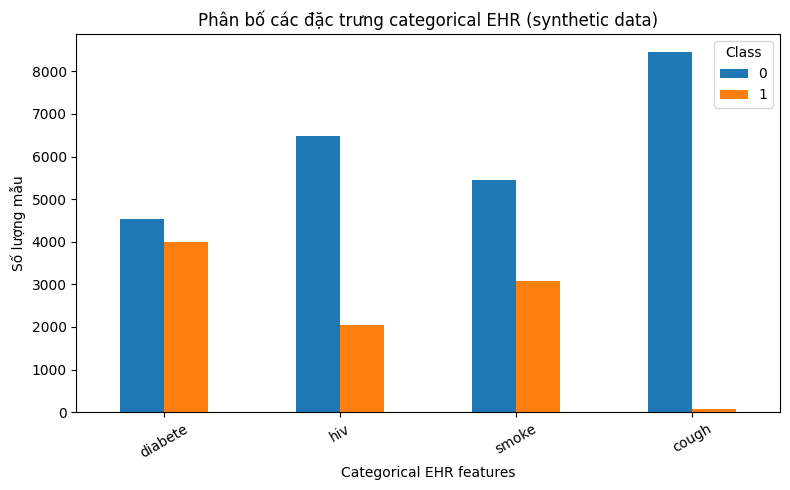

In [ ]:
cat_feats = ['diabete', 'hiv', 'smoke', 'cough']

summary_cat = {}

for col in cat_feats:
    counts = df_summary.loc[col]   # hoặc xtr[col].value_counts()
    summary_cat[col] = {
        '0': counts.get(0, 0),
        '1': counts.get(1, 0)
    }

df_cat = pd.DataFrame(summary_cat).T

df_cat.plot(
    kind='bar',
    figsize=(8, 5)
)

plt.xlabel('Categorical EHR features')
plt.ylabel('Số lượng mẫu')
plt.title('Phân bố các đặc trưng categorical EHR (synthetic data)')
plt.xticks(rotation=30)
plt.legend(title='Class')
plt.tight_layout()
plt.show()

In [ ]:
X_train_final

,0,1,2,3,4,5,6,7,8,9,...,age,hiv,oxygen,heart_rate,temperature,hemoglobin,rbc,wbc,smoke,cough
0,0.856242,-1.470453,1.117912e-39,-4.006925,-0.386026,-8.627420e-40,-2.084280e-39,0.193751,-1.698623,3.912998e-39,...,91.0,0.0,NaN,NaN,NaN,14.9,5.14,7.1,0.0,0.0
1,0.831896,-0.041840,-8.851540e-40,-3.207264,0.754563,-9.765680e-40,9.305210e-40,0.623604,-0.516955,2.885869e-39,...,80.0,0.0,NaN,NaN,NaN,7.2,2.55,7.7,0.0,0.0
2,-1.899727,-2.557168,3.806278e-39,-3.168871,-1.468932,1.358532e-39,4.534360e-40,-1.675298,-3.984909,-1.519668e-39,...,46.0,0.0,NaN,NaN,NaN,10.1,3.29,4.1,0.0,0.0
3,1.983838,2.022925,-1.033420e-39,-3.809005,1.222515,-1.458293e-39,4.515670e-40,3.482653,-0.884112,3.398606e-39,...,69.0,0.0,NaN,NaN,NaN,10.0,3.59,3.1,0.0,0.0
4,1.859526,1.281903,-9.649960e-40,-2.584149,0.829963,-2.116862e-39,9.096500e-40,2.426933,-0.563089,2.743082e-39,...,68.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27431,1.314655,-0.524357,6.120979e-40,-3.360817,-0.088115,6.665970e-40,1.447505e-39,1.126122,-1.264672,2.539812e-39,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
27432,-0.451817,-2.294229,1.568861e-39,-4.110234,-0.422296,6.482883e-40,1.109287e-39,-0.671879,-2.014987,1.101972e-39,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
27433,0.218326,-3.026485,-2.645545e-41,-3.765365,-0.990047,-4.466595e-39,-1.860362e-39,-1.392493,-1.037514,2.442908e-39,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
27434,0.110651,-0.169059,3.897490e-40,-2.435419,-0.581928,-6.517955e-40,3.000839e-39,0.820376,-1.077453,4.680284e-40,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0


In [ ]:
mimic_numeric = ['oxygen', 'heart_rate', 'temperature',
                   'hemoglobin', 'rbc', 'wbc']

models_mask = {}
models_value = {}

In [ ]:
mimic_numeric = ['oxygen', 'heart_rate', 'temperature',
                   'hemoglobin', 'rbc', 'wbc']
models_mask = {}
models_value = {}

for num in mimic_numeric:
    mask = xtr[num].notna().astype(int)
    n_pos = mask.sum()
    n_neg = len(mask) - n_pos

    X_train_num_input = pd.concat([X_train_img, X_train_labels], axis=1)

    mask_model = XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        scale_pos_weight = n_neg / n_pos
    )

    mask_model.fit(X_train_num_input, mask)
    models_mask[num] = mask_model

    value_model = XGBRegressor(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    value_model.fit(X_train_num_input[mask == 1], xtr.loc[mask == 1, num])
    models_value[num] = value_model


X_synth_input = pd.concat([X_synth_img, X_train_final.loc[n_original:, cat_feats]], axis=1)

for num in mimic_numeric:
    mask_pred = models_mask[num].predict(X_synth_input)
    idx_has_value = (mask_pred == 1)

    if idx_has_value.sum() > 0:
        values = models_value[num].predict(X_synth_input[idx_has_value])
        X_train_final.loc[n_original:].loc[idx_has_value, num] = values
X_train_final

,0,1,2,3,4,5,6,7,8,9,...,age,hiv,oxygen,heart_rate,temperature,hemoglobin,rbc,wbc,smoke,cough
0,0.856242,-1.470453,1.117912e-39,-4.006925,-0.386026,-8.627420e-40,-2.084280e-39,0.193751,-1.698623,3.912998e-39,...,91.0,0.0,NaN,NaN,NaN,14.900000,5.140000,7.100000,0.0,0.0
1,0.831896,-0.041840,-8.851540e-40,-3.207264,0.754563,-9.765680e-40,9.305210e-40,0.623604,-0.516955,2.885869e-39,...,80.0,0.0,NaN,NaN,NaN,7.200000,2.550000,7.700000,0.0,0.0
2,-1.899727,-2.557168,3.806278e-39,-3.168871,-1.468932,1.358532e-39,4.534360e-40,-1.675298,-3.984909,-1.519668e-39,...,46.0,0.0,NaN,NaN,NaN,10.100000,3.290000,4.100000,0.0,0.0
3,1.983838,2.022925,-1.033420e-39,-3.809005,1.222515,-1.458293e-39,4.515670e-40,3.482653,-0.884112,3.398606e-39,...,69.0,0.0,NaN,NaN,NaN,10.000000,3.590000,3.100000,0.0,0.0
4,1.859526,1.281903,-9.649960e-40,-2.584149,0.829963,-2.116862e-39,9.096500e-40,2.426933,-0.563089,2.743082e-39,...,68.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27431,1.314655,-0.524357,6.120979e-40,-3.360817,-0.088115,6.665970e-40,1.447505e-39,1.126122,-1.264672,2.539812e-39,...,NaN,0.0,NaN,NaN,99.937584,10.105831,3.461012,9.361312,0.0,0.0
27432,-0.451817,-2.294229,1.568861e-39,-4.110234,-0.422296,6.482883e-40,1.109287e-39,-0.671879,-2.014987,1.101972e-39,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
27433,0.218326,-3.026485,-2.645545e-41,-3.765365,-0.990047,-4.466595e-39,-1.860362e-39,-1.392493,-1.037514,2.442908e-39,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
27434,0.110651,-0.169059,3.897490e-40,-2.435419,-0.581928,-6.517955e-40,3.000839e-39,0.820376,-1.077453,4.680284e-40,...,NaN,0.0,NaN,NaN,NaN,10.481538,3.582344,8.412535,1.0,0.0


In [ ]:
X_synth = X_train_final.loc[n_original:, mimic_numeric]

summary_num = {}

for col in mimic_numeric:
    nan_count = X_synth[col].isna().sum()
    non_nan_count = X_synth[col].notna().sum()

    summary_num[col] = {
        "NaN": nan_count,
        "Non-NaN": non_nan_count
    }

df_summary_num = pd.DataFrame(summary_num).T
print(df_summary_num)

              NaN  Non-NaN
oxygen       5727     2806
heart_rate   4879     3654
temperature  4902     3631
hemoglobin   3127     5406
rbc          3127     5406
wbc          3127     5406


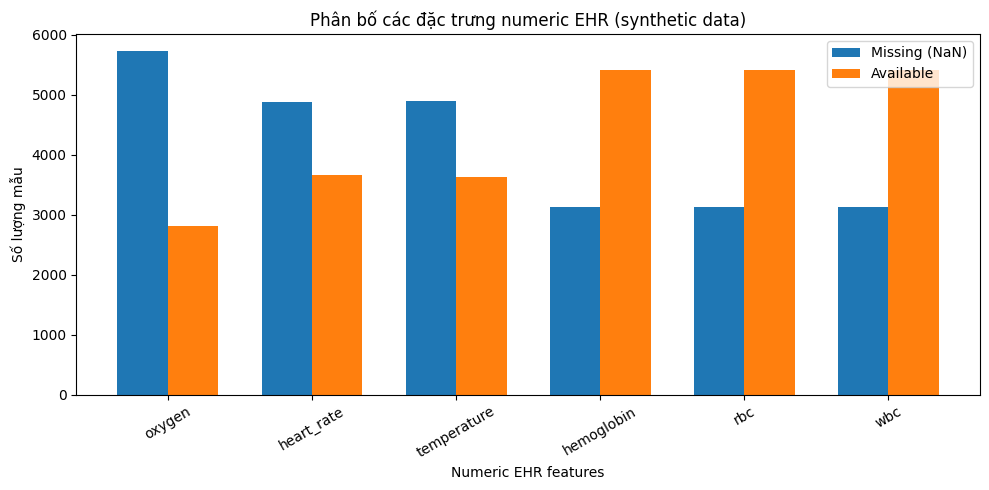

In [ ]:
labels = df_summary_num.index
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 5))

plt.bar(x - width/2, df_summary_num['NaN'], width, label='Missing (NaN)')
plt.bar(x + width/2, df_summary_num['Non-NaN'], width, label='Available')

plt.xticks(x, labels, rotation=30)
plt.xlabel('Numeric EHR features')
plt.ylabel('Số lượng mẫu')
plt.title('Phân bố các đặc trưng numeric EHR (synthetic data)')
plt.legend()

plt.tight_layout()
plt.show()
